### Replicates and linear regression

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd

In [2]:
# N = 1000
# num_boot = 10000
# num_donors = 3
# donors = np.random.choice(['a','b','c'], size=N)
# endog = np.random.randint(2, size=N).reshape(-1,1)

# donor_indicator = OneHotEncoder().fit_transform(donors.reshape(-1,1)).toarray()
# X = np.hstack([endog, donor_indicator])
# beta = np.array([50, 40, 20, 30]).reshape(-1,1)
# noise = stats.norm.rvs(loc=0*np.ones(N)*(donors=='a')*(endog.reshape(-1)==1), scale=100,).reshape(-1,1)
# noise = stats.norm.rvs(scale=100, size=N).reshape(-1,1)
# exog = X@beta + noise

In [8]:
N = 20
num_boot = 20000
num_donors = 3
donors = np.random.choice(['a','b','c'], size=N)
endog = np.random.randint(2, size=N).reshape(-1,1)

donor_indicator = OneHotEncoder().fit_transform(donors.reshape(-1,1)).toarray()
X = np.hstack([endog, donor_indicator])
beta = np.array([50, 10, 20, 30]).reshape(-1,1)

exog = X@beta + \
    60*np.ones(N)*(donors=='a')*(endog.reshape(-1)==1) + \
    25*np.ones(N)*(donors=='b')*(endog.reshape(-1)==1) + \
    stats.norm.rvs(loc=0, scale=20, size=N).reshape(-1,1)

### Code for actual linear regression

In [33]:
linreg_coefs = np.zeros(num_boot)
# X = np.hstack([X, X[:, [0]]*X[:, [1]], X[:, [0]]*X[:, [2]], X[:, [0]]*X[:, [3]]])
for b in range(num_boot):
    boot_idxs = np.random.choice(N, size=N)
    linreg_coefs[b] = LinearRegression(fit_intercept=False).fit(X[boot_idxs],exog[boot_idxs]).coef_[0,0]

### Code for separate regression

In [34]:
donor_data = []
for donor in ['a', 'b', 'c']:
    X_donor = endog[donors==donor].copy()
    exog_donor = exog[donors==donor].copy()
    donor_data.append((X_donor, exog_donor))

In [35]:
weighted_coefs = np.zeros(num_boot)
for b in range(num_boot):
    
    for X_donor, exog_donor in donor_data:
        
        boot_idxs = np.random.choice(X_donor.shape[0], size=X_donor.shape[0])
        weighted_coefs[b] += LinearRegression(fit_intercept=True).fit(X_donor[boot_idxs],exog_donor[boot_idxs]).coef_[0,0]*X_donor.shape[0]
    
    weighted_coefs[b] /= N

<AxesSubplot:ylabel='Density'>

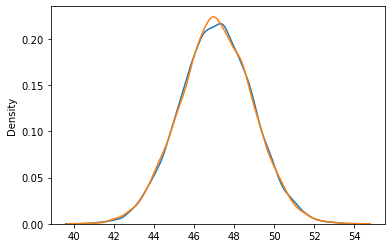

In [36]:
sns.kdeplot(linreg_coefs)
sns.kdeplot(weighted_coefs)

In [37]:
X

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [38]:
cov_idx = 0

In [18]:
strata = np.delete(X, 0, axis=1)
uniq_strata, indices, inverse = np.unique(np.delete(X, 0, axis=1), axis=0, return_inverse=True, return_index=True)

In [19]:
indices

array([0, 5, 1])

In [14]:
inverse

array([0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0])

In [21]:
np.where(inverse==0)[0]

array([ 0,  3,  4, 10, 19])

In [23]:
import scipy.sparse as sparse

In [27]:
sparse.eye(5).tocsr()[:, 0]

<5x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [28]:
np.concatenate([np.array([1, 2, 3]), np.array([5, 3])])

array([1, 2, 3, 5, 3])

In [30]:
sparse.vstack([sparse.eye(5), sparse.eye(5)])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>

In [38]:
def a():
    return 'a', 'b', 'c'

In [39]:
b = {1:a()}

In [40]:
b

{1: ('a', 'b', 'c')}

In [34]:
(xyz if 1==1 else 'abc')

NameError: name 'xyz' is not defined

In [40]:
strata_idx = np.all(strata == uniq_strata[0], axis=1)

In [41]:
X[strata_idx][:, [0,1]].shape

(128, 2)

In [42]:
df = pd.DataFrame(uniq_strata, columns=['A', 'B', 'C'])

In [24]:
from patsy import dmatrix

In [4]:
N = 10
df = pd.DataFrame()
df['treatment'] = np.random.choice(['A', 'B', 'C', 'D'], size=N)
df['covariate'] = np.random.choice(2, size=N)
design_df = df.copy()
formula_like = '1 + treatment + covariate'

dmat = dmatrix(formula_like, design_df)
design_matrix_cols = dmat.design_info.column_names.copy()
design_matrix = np.array(dmat)
del dmat


NameError: name 'dmatrix' is not defined

In [35]:
df

,treatment,covariate
0,A,1
1,A,1
2,D,1
3,C,1
4,A,0
...,...,...
95,A,1
96,A,1
97,B,0
98,D,0


In [36]:
design_matrix_cols

['Intercept',
 'treatment[T.B]',
 'treatment[T.C]',
 'treatment[T.D]',
 'covariate']

In [37]:
np.unique(design_matrix, axis=0)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1.]])